# Import packages and read in data

In [31]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [32]:
# Read in data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
original_df = pd.read_csv('credit_risk_dataset.csv')

# Combine training and original data
train_df = train_df.drop('id', axis=1)
train_df = pd.concat([train_df, original_df])

# Print head
train_df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [33]:
# Check dataframe info
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 91226 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB
None


# Check duplicates and null values

In [34]:
# Loan status into object for visuals
train_df['loan_status'] = train_df['loan_status'].astype('object')

In [35]:
# Check & Drop duplicates
print(train_df.duplicated().sum())
train_df = train_df.drop_duplicates().reset_index(drop = True)

165


In [36]:
# Check null values
print(pd.isnull(train_df).sum())

# Fill in missing values with median
train_df['person_emp_length'] = train_df['person_emp_length'].fillna(train_df['person_emp_length'].median())
train_df['loan_int_rate'] = train_df['loan_int_rate'].fillna(train_df['loan_int_rate'].median())

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64


# Data Exploration

## Numeric columns - histograms and boxplots

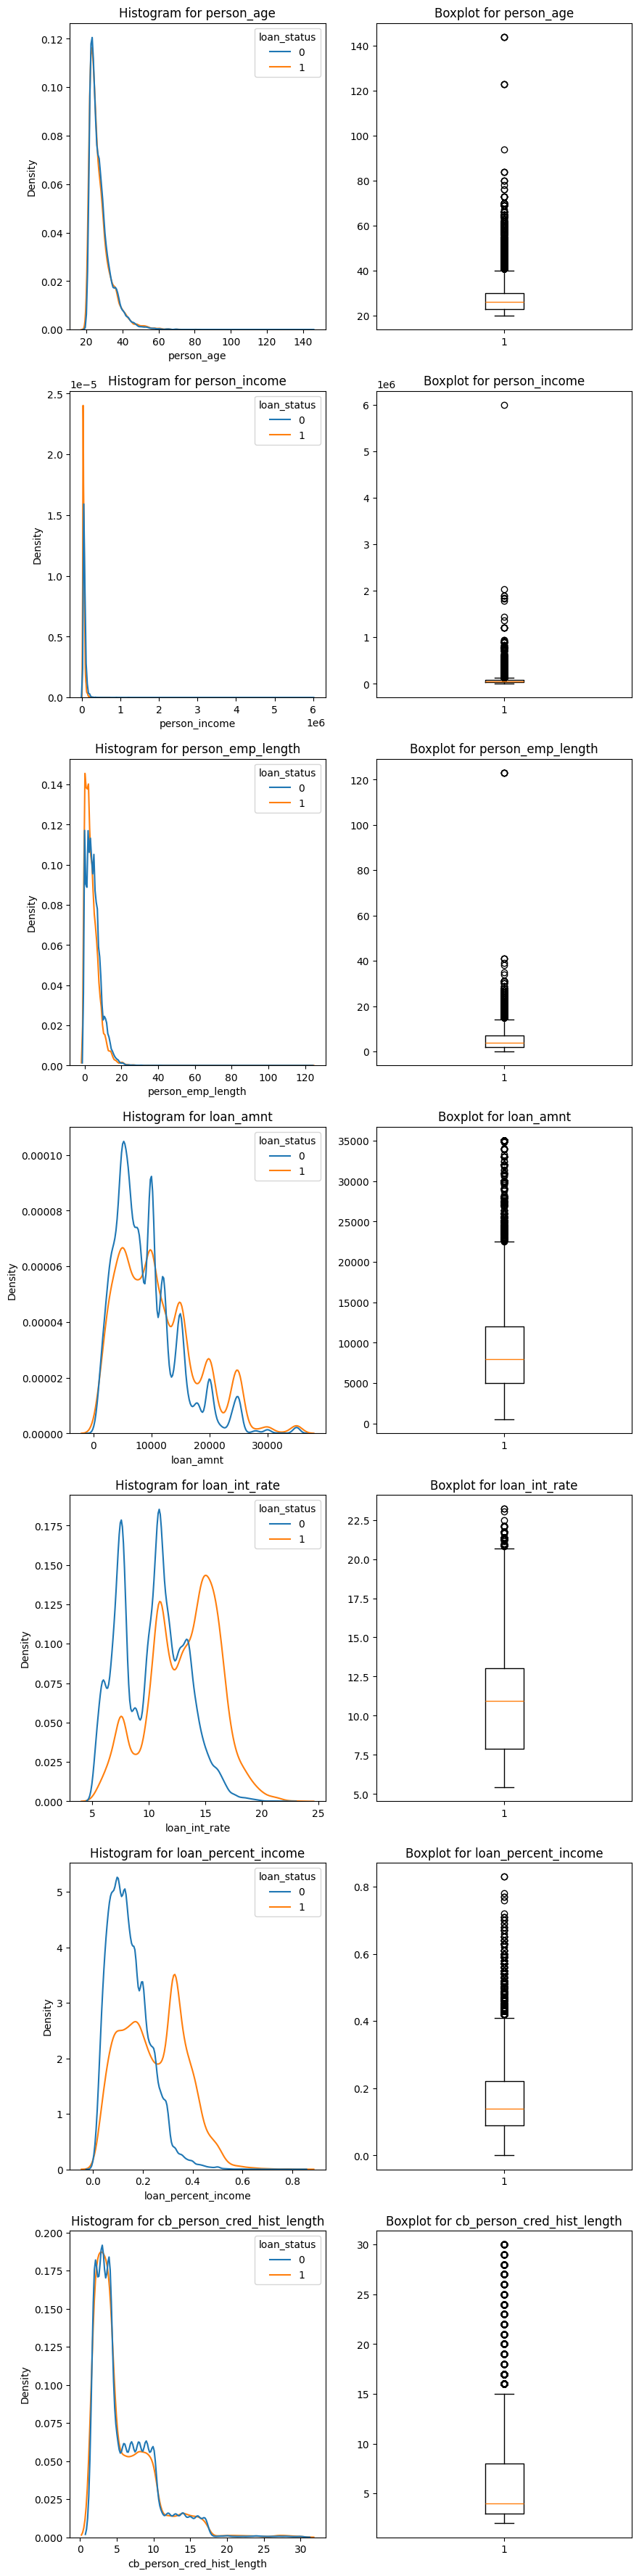

In [37]:
# Get numeric columns
num_vars = list(train_df.select_dtypes(['int', 'float']).columns)

# Create subplot
fig, ax = plt.subplots(7,2, figsize = (10,45))

# Plot
for i, x in enumerate(num_vars):
    ax[i,0].set_title(f'Histogram for {x}')
    ax[i,1].set_title(f'Boxplot for {x}')
    sns.kdeplot(train_df, x = x, hue = 'loan_status', common_norm=False, ax = ax[i,0])
    ax[i,1].boxplot(train_df[x])

### Address large outliers in person_age and person_emp_length

In [38]:
# Several people aged above 120. Replace with median age
train_df.loc[train_df['person_age'] >120,'person_age'] = np.median(train_df['person_age'])

# Several people employment length above 100. Replace with median
train_df.loc[train_df['person_emp_length'] > 100,'person_emp_length'] = np.median(train_df['person_emp_length'])

## Non-Numeric columns - pie chart and count plots

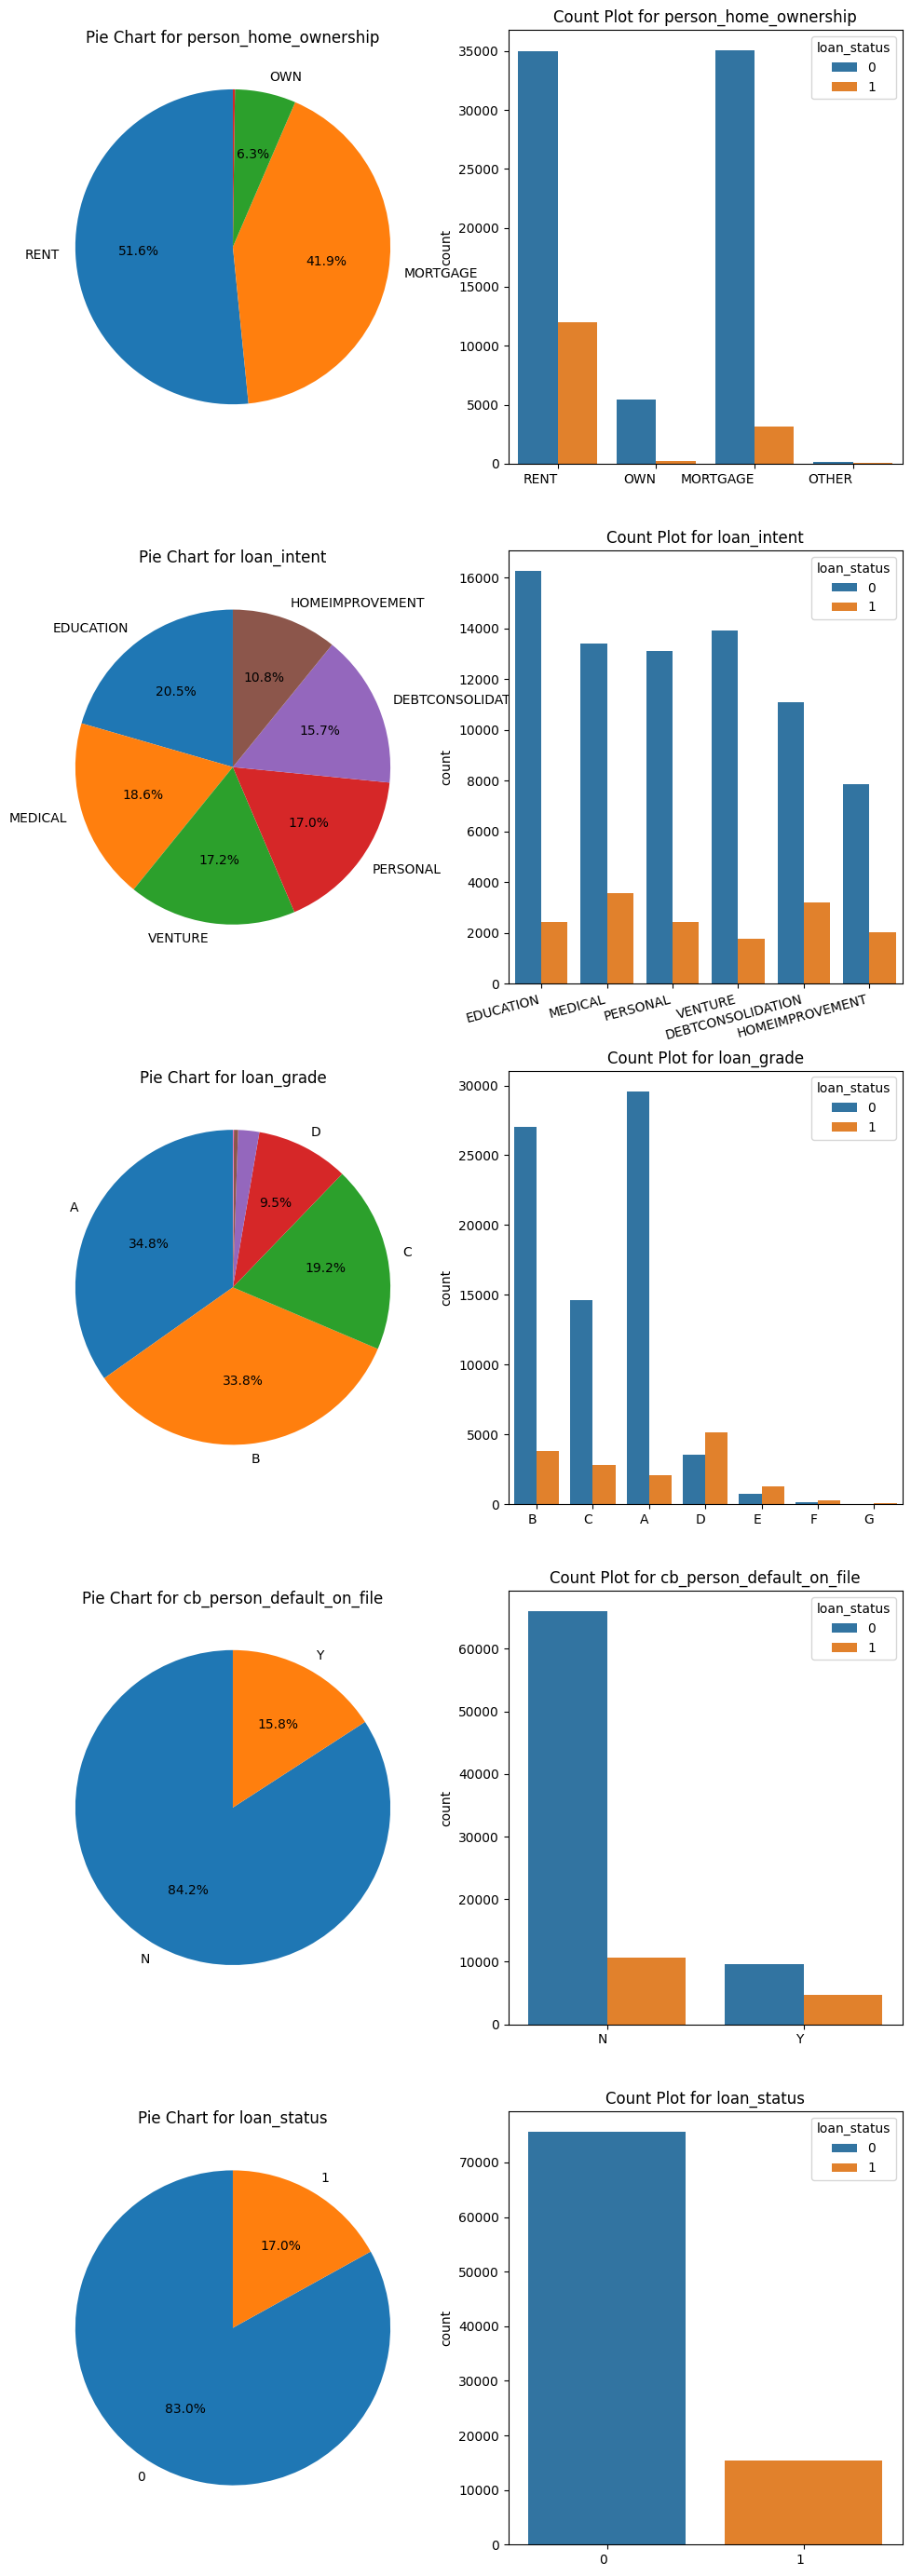

In [39]:
# Get non-numeric columns
obj_vars = list(train_df.select_dtypes('object'))

# Create subplot
fig, ax = plt.subplots(5, 2, figsize = (12, 25))

# Plot
for i,x in enumerate(obj_vars):
    data = pd.DataFrame(train_df[x].value_counts(normalize=True)).reset_index()
    data['proportion'] = data['proportion'] * 100
    labels = [data[x][y] if data['proportion'][y] >5 else '' for y in range(len(data))]
    ax[i,0].pie(data['proportion'], labels = labels,
              autopct = lambda pct: f'{pct:.1f}%' if pct>5 else '', startangle = 90)
    ax[i,0].set_title(f'Pie Chart for {x}')
    ax[i,1].set_title(f'Count Plot for {x}')
    sns.countplot(train_df, x=x, hue = 'loan_status', ax=ax[i,1])
    if x == 'loan_intent':
        ax[i,1].set_xticklabels(ax[i,1].get_xticklabels(), rotation=15, ha = 'right')
    else:
        ax[i,1].set_xticklabels(ax[i,1].get_xticklabels(), rotation=0, ha = 'right')
    ax[i,1].set(xlabel=None)
    plt.subplots_adjust(bottom=-0.2)

### Overwhelming number of loans are rejected - about 85-15

## Correlation

<Axes: >

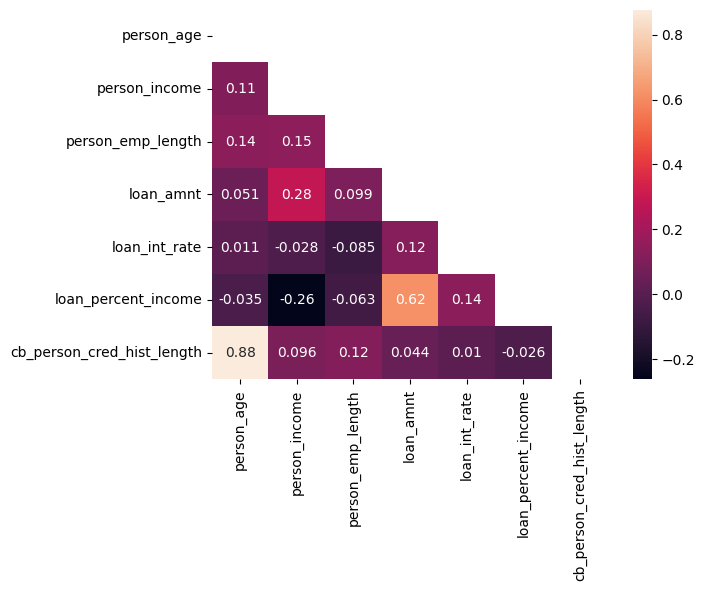

In [40]:
# Correlation for numeric variables
cont_df = train_df[num_vars]
corr_matrix = cont_df.corr()
mask = np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot = True, mask=mask)

### High correlation between credit history length and age; and loan amount and the loan percentage of income

# Statistical Testing